In [1]:
import numpy as np
import scipy as sp
import autograd 

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
import common_modeling_lib as common_model_lib

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

np.random.seed(453453)



# Load data

In [2]:
# set up R chunks 
%load_ext rpy2.ipython
%R require(ggplot2)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
# load iris dataset 

from sklearn import datasets

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]
iris_species = iris[1]

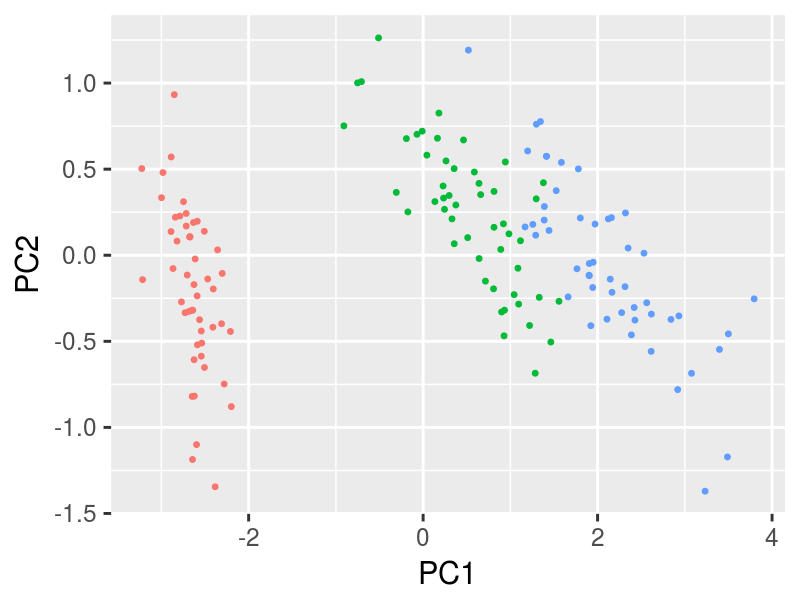

In [4]:
%%R -i iris_features -i iris_species -w 4 -h 3 --units in -r 200

    iris_df <- as.data.frame(iris_features)
    iris_df$species <- iris_species
    pca_results <- prcomp(iris_features)
    
    df_pca <- as.data.frame(pca_results$x)
    df_pca$species <- as.factor(iris_species)
    ggplot(df_pca) + geom_point(aes(x = PC1, y = PC2, color = species), size = 0.5) + 
        theme(legend.position="none") 

# Set prior params

In [5]:
prior_params = gmm_utils.get_default_prior_params()

In [6]:
print(prior_params)

prior_params:
	alpha: 2.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_shape: 10.0
	prior_gamma_scale: 0.1


# Set up model

In [7]:
k_approx = 10
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg)

In [8]:
# Check our implementation of the likelihood

In [9]:
model.set_random()

In [10]:
def likelihood_nk_slow_implementation(y, vb_params): 
    centroids = vb_params['global']['centroids'].get()
    gamma = vb_params['global']['gamma'].get()

    n_obs = np.shape(y)[0]
    k_approx = np.shape(centroids)[1]
    dim = np.shape(centroids)[0]
    
    likelihood_nk = np.zeros((n_obs, k_approx))
    squared_term = np.zeros((n_obs, k_approx))
    for n in range(n_obs): 
        for k in range(k_approx): 
            squared_term[n, k] = np.sum((y[n, :] - centroids[:, k])**2)
            likelihood_nk[n, k] = dim / 2 * np.log(gamma) - squared_term[n, k] * gamma / 2
    
    return(likelihood_nk, squared_term)

In [11]:
likelihood_nk, squared_term = likelihood_nk_slow_implementation(model.y, model.vb_params)

In [12]:
np.max(np.abs(gmm_utils.get_loglik_obs_by_nk(model.y, model.vb_params) - likelihood_nk))

2.1316282072803006e-14

In [13]:
# check our z updates: 

In [14]:
def get_e_log_lik_from_e_z(e_z, model):
    model.vb_params['e_z'].set(e_z)
    elbo = -1 * model.get_kl()
    return elbo - common_model_lib.multinom_entropy(model.vb_params['e_z'].get())

In [15]:
e_z = model.vb_params['e_z'].get()
get_e_z_nat_params = autograd.grad(get_e_log_lik_from_e_z, argnum = 0)
autodiff_e_z_nat_params = get_e_z_nat_params(e_z, model)

In [16]:
np.max(np.abs(autodiff_e_z_nat_params - model.get_z_nat_params()))

1.4210854715202004e-14